<a href="https://colab.research.google.com/github/sb8919/Travelplus/blob/main/DL_model/BERT_%ED%83%9C%EA%B7%B8_200%EA%B0%9C%EC%94%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# 패키지 다운로드
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
# 주요 패키지 불러오기
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

In [21]:
# GPU 확인
n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


-------------

In [22]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# 라벨링 파일 데이터 프레임 형태로 가져오기
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/labeling_data_0521.xlsx')

In [24]:
# 인스타그램 본문 내용에서 특수문자 공백으로 교환
df["sentences"] = df["sentences"].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

In [25]:
# 인스타그램 태그 내용에서 특수문자 공백으로 교환
df["tags"] = df["tags"].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

In [26]:
# 10개의 데이터 랜덤으로 출력
df.sample(n=10)

,Unnamed: 0,sentences,tags,place,label
4583,4583,영등포 타임스퀘어 데이트 핫플 모음집 맛집부터 카페 실내동물원 공방까지 다 ...,영등포가볼만한곳 영등포핫플 타임스퀘어 영등포역 영등포데이트,NaN,3.0
6729,6729,_____ 배말칼국수김밥 통영 신선한 식재료라 그런지 몸보신 하는 기분,통영서피랑맛집 서피랑맛집 통영죽림맛집 죽림맛집 통영가볼만한곳 통...,NaN,1.0
2466,2466,겨울은 겨울이구나추위때문에 손이 시려워 꽁 ㅋ감악산 출렁다리 갔다가 카페에서 따뜻...,파주출렁다리 파주여행코스 파주겨울여행 감악산출렁다리 글로스터영웅의다...,감악산 출렁다리,1.0
1064,1064,둘이먹다 하나가 없어져도 모를 맛맛으로 승부하는 진짜 맛있는집,먹골갈비직접 아산맛집 아산스파비스맛집 영인산맛집 피나클랜드맛집 ...,NaN,8.0
5314,5314,그냥 먹어도 맛있는 갈비 김치찜 맛은 물론 서비스까지만족시켜 드릴게요 부드러운 식...,옛촌매운갈비찜 송파맛집 방이동맛집 방이맛집 방이먹자골목맛집 잠실...,NaN,1.0
3120,3120,농기센을 우리집 드나들듯이 ㅋㅋ일주일에 한번은 가는듯 갈때마다 새로운 꽃과 식물 ...,안동놀러갈만한곳 농업기술센터 아이들이좋아해 집에서,NaN,2.0
1880,1880,함평에도,첫눈이 함평한옥마을의첫눈넘 윤슬한옥의겨울 윤슬한옥겨울풍경넘 눈구경 ...,NaN,7.0
3367,3367,전남국제문화교류센터 의 문화룸 이 새단장 되었어요 주된 활동은 1 서로배우는소사...,광양영어회화 광양맘 광양영어과외 광양자녀교육 광양문화생활 광양문...,전라남도 광양,7.0
889,889,남원 여행중에 먹은 음식 남원이조갈비,Korean 남원여행 전북여행 국내여행 엄마랑여행 남원켄싱턴리조...,NaN,1.0
5443,5443,혼술하기 좋은 분위기로 꾸며진 대전 유성구,오늘한잔오뗑 훈제오리구이 왕계란말이 오뎅꼬치 유성오뎅바 구암동오...,NaN,8.0


In [31]:
# label 열의 값 float-> str
df['label'] = df['label'].astype(str)

In [32]:
# label 분류 숫자로 변경
df.loc[(df['label'] == "0.0"), 'label'] = 0  #0.0 => 스팸 => 0
df.loc[(df['label'] == "1.0"), 'label'] = 1  #1.0 => 가볼만한곳 => 1
df.loc[(df['label'] == "2.0"), 'label'] = 2  #2.0 => 가족여행 => 2
df.loc[(df['label'] == "3.0"), 'label'] = 3  #3.0 => 관람 => 3
df.loc[(df['label'] == "4.0"), 'label'] = 4  #4.0 => 맛집 => 4
df.loc[(df['label'] == "5.0"), 'label'] = 5  #5.0 => 우정여행 => 5
df.loc[(df['label'] == "6.0"), 'label'] = 6  #6.0 => 전통 => 6
df.loc[(df['label'] == "7.0"), 'label'] = 7  #7.0 => 체험 => 7
df.loc[(df['label'] == "8.0"), 'label'] = 8  #8.0 => 카페 => 8
df.loc[(df['label'] == "9.0"), 'label'] = 9  #9.0 => 캠핑핑 => 9

<Axes: >

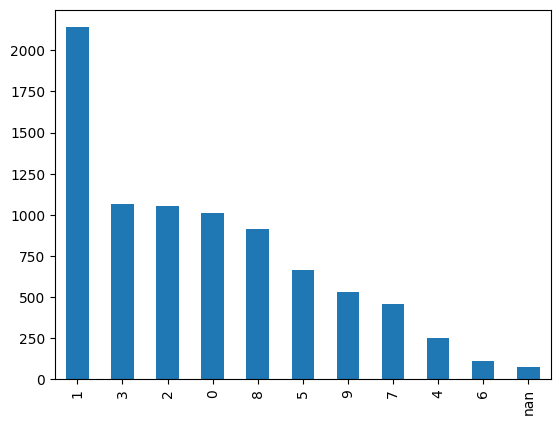

In [33]:
# 데이터 정제하기
# label 값 분포 확인
df['label'].value_counts().plot(kind = 'bar')

In [34]:
# 각 label 별 갯수 확인
df['label'].value_counts()

1      2141
3      1067
2      1053
0      1011
8       915
5       664
9       531
7       457
4       253
6       110
nan      73
Name: label, dtype: int64

In [36]:
# Null 값 유무 확인 True <- Null 값 있음
print(df.isnull().values.any())

True


In [37]:
# 어떤 열에서 Null 값 존재하는지 확인
print(df.isnull().sum())

Unnamed: 0       0
sentences        1
tags             0
place         5246
label            0
dtype: int64


In [38]:
# Null 값 많은 place 열 제거
df = df.drop('place',axis=1)

In [39]:
# 데이터 확인
df

,Unnamed: 0,sentences,tags,label
0,0,술이 달다 라고 하는걸 이걸보구 말하나봐요알쓰들도 무한대로 마실수 있는 연말을 ...,선릉 평상술집 술 술집 술안주 꿀주 꿀막걸리 막걸리 ...,8
1,1,,강남카페 강남대형카페도심 카즐_서울 카즐_강남 카즐_가로수길 카...,1
2,2,,강남카페 강남대형카페도심 카즐_서울 카즐_강남 카즐_가로수길 카...,2
3,3,연타발 압구정 완전 대박인듯ㅜㅜ어느 하나 모자람없는 이 맛을 다양한 세계로 이끌어가...,도산공원맛집 연타발압구정본점 강남맛집 신사동맛집 압구정맛집 도산...,1
4,4,연타발 압구정 완전 대박인듯ㅜㅜ어느 하나 모자람없는 이 맛을 다양한 세계로 이끌어가...,도산공원맛집 연타발압구정본점 강남맛집 신사동맛집 압구정맛집 도산...,8
...,...,...,...,...
8270,8270,올드카에 관심 있다면 규슈 자동차 박물관2023 03 08,사진 여행사진 일본 여행 유후인 일본여행 후쿠오카 규슈 ...,7
8271,8271,조선의 외교관 역관 부산박물관 특별기획전 전시관람하고 왔어요 아직 어린 아들...,부산박물관 특별기획전 전시관람 전시연출 박물관 포토스팟 역관...,7
8272,8272,어벤져스 엔드게임의 감동을 다시 한 번 피규어뮤지엄제주 2023 03 15,사진 여행사진 한국 제주 여행 풍경 한국여행 제주도 ...,7
8273,8273,사 한국박물관협회 회장 조한희 는 지난 5월 11일 목 부터 13일 토 까지 3일...,한국박물관협회 한박협 뮤지엄 박물관 미술관 제17회한국박물관국제...,0


In [40]:
# 어떤 열에서 Null 값 존재하는지 확인
print(df.isnull().sum())

Unnamed: 0    0
sentences     1
tags          0
label         0
dtype: int64


In [41]:
# Null값 제거
df = df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(df.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [42]:
# Null값 제거 후 데이터 개수 확인
print(len(df))

8274


In [43]:
# 라벨 값별로 200개씩만 선택
label_counts = df['label'].value_counts()
selected_indices = []
for label in label_counts.index:
    label_indices = df[df['label'] == label].index.tolist()
    selected_indices += label_indices[:200]
selected_df = df.loc[selected_indices]

# 결과 확인
print(selected_df['label'].value_counts())


1      200
3      200
2      200
0      200
8      200
5      200
9      200
7      200
4      200
6      110
nan     73
Name: label, dtype: int64


In [44]:
df = selected_df

1    200
3    200
2    200
0    200
8    200
5    200
9    200
7    200
4    200
6    110
Name: label, dtype: int64


1910

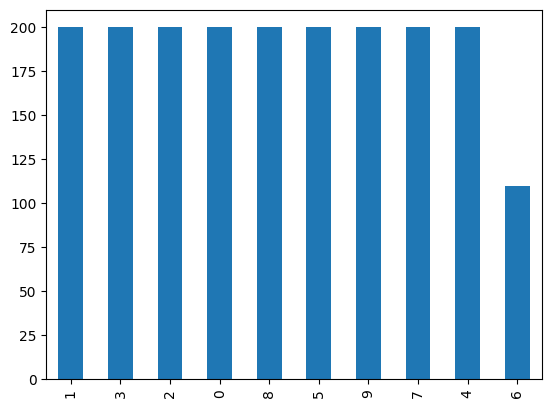

In [50]:
# 각 label별 갯수 확인
df['label'].value_counts().plot(kind = 'bar')
print(df['label'].value_counts())
len(df)

In [51]:
# label에서 nan 제거
df = df[df.label != 'nan']

1    200
3    200
2    200
0    200
8    200
5    200
9    200
7    200
4    200
6    110
Name: label, dtype: int64


1910

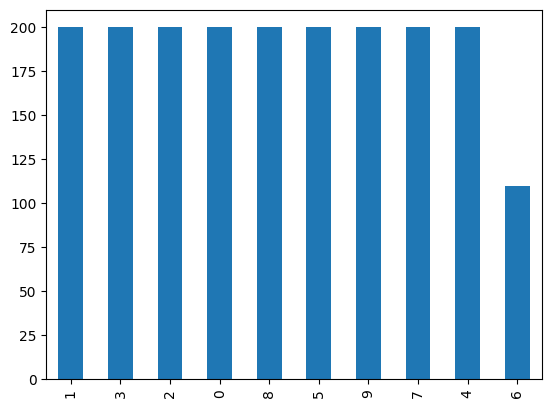

In [52]:
# 각 label별 갯수 확인
df['label'].value_counts().plot(kind = 'bar')
print(df['label'].value_counts())
len(df)

In [53]:
# data_list에 본문과 라벨링된 값 저장장
data_list = []
for q, label in zip(df['tags'], df['label'])  :
    if q.strip() == '' or q.strip() == '.':
        print(q)
        continue
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [54]:
print(data_list[0])
print(data_list[500])
#print(data_list[1200])
# print(data_list[1800])
# print(data_list[2400])
# print(data_list[2800])
# print(data_list[-1])

[' 강남카페   강남대형카페도심   카즐_서울   카즐_강남   카즐_가로수길   카즐_신사   카즐_도산   강남카페추천   강남데이트코스   강남가볼만한곳   강남핫플   강남맛집   강남브런치', '1']
[' 고흥여행   고흥민박   고흥펜션   고흥1박2일   고흥가볼만한곳   고흥나들이   고흥커플여행   커플여행   주말여행   여름휴가   고흥휴가   고흥여름휴가   전남고흥   전남가볼만한곳   전남여행   전남나들이   전남휴가   전라남도여행추천   고흥여행코스   고흥1박2일여행코스   연흥도   쑥섬   애도   금산해안경관   소원동산   시비공원   유자막걸리   고흥숙박   용바위   전망좋은곳', '2']


In [55]:
#train & test 데이터로 나누기 train 80 test 20
from sklearn.model_selection import train_test_split
                                                         
train, test = train_test_split(df, test_size=0.2, random_state=0)

In [57]:
# train data, test data 개수 확인
print(len(train))
print(len(test))

1528
382


In [58]:
print(train)

      Unnamed: 0                                          sentences  \
1989        1989                                             이번 설날    
866          866  부산에서 오신 고객분   너무 예쁜사진 감사합니다  오시는 분들마다 창찬을 아끼지않...   
7032        7032                                            세계 각국의    
782          782    2023 열린모작실 season 1  조개줍깅 X 모래알U0001fab8바다모빌...   
2019        2019                                    청양 맛과 멋을 이야기하는    
...          ...                                                ...   
271          271       광고강릉최고의 특상 1  투플 한우금송아지예약문의 010 3153 1245      
193          193                                           주말엔 달달한    
5023        5023  내가 좋아하는 동네    진관사가 있고고즈넉한 한옥들이 있고 전시도 있고  찻집도 ...   
870          870                                   너무 예뻐서 사진 펌 합니다    
995          995   세상 다소곳한 척  주변에 사람많았는ᄃ...   

                                                   tags label  
1989   해미읍성   민속행사   여행공유환영   맛집공유환영   서산지기_여기가주세요_환...     4  
866    안동숙소   안동숙소추

------

In [59]:
# CLS, SEP 붙이기 (문장의 시작, 끝)
document_bert = ["[CLS] " + str(s) + " [SEP]" for s in train.tags]

In [60]:
document_bert[:5]

['[CLS]  해미읍성   민속행사   여행공유환영   맛집공유환영   서산지기_여기가주세요_환영   제보는_프로필_링크클릭        서산   서산여행   서산가볼만한곳   서산여행지   서산포토존   서산볼거리   서산커플여행   서산우정여행   서산가족여행   서산명소   서산힐링   서산여행지추천   충남가볼만한곳   충남여행지추천   서산놀거리   서산겨울여행   서산명절   서산설날놀거리   서산아이들   서산민속체험   서산전통체험   서산해미읍성   해미면   서산민속가옥 [SEP]',
 '[CLS]  안동숙소   안동숙소추천   안동여행   안동펜션   안동펜션추천   대구근교여행   안동커플여행   안동가족여행   안동카페   안동맛집   안동맛집추천   경북여행   경북숙소   안동한옥   안동한옥스테이   안동한옥펜션   숙소추천   감성숙소   안동에어비앤비   한래소담   자쿠지숙소   경북자쿠지숙소   경북자쿠지   안동자쿠지숙소   안동자쿠지   안동놀거리   안동데이트   안동맘   안동핫플   안동데이트코스 [SEP]',
 '[CLS]  문화   체험   글로벌   데이5 15  월  5 19  금    충청북도국제교육원   중부분원   진천군   덕산읍   인석로   문화체험   글로벌데이   다문화   중국   일본   필리핀   미국   멕시코   스코틀랜드   러시아   목공예체험   우리꽃차체험   세계명소   캐리커쳐   프랑스요리 [SEP]',
 '[CLS]  속초   속초여행   속초소품샵   속초원데이클래스   바다모빌만들기   속초체험   속초체험공방   속초우정여행   속초커플여행   속초카페   속초맛집   문우당서림   원데이클래스   바다모빌체험   모빌만들기체험   속초만들기체험   청년작가   로컬상점   속초로컬상점   모래알   속초모래알   열린모작실   지역작가   로컬   로컬크리에이터   [SEP]',
 '[CLS]  청양향토식당우거디밥이맛있는집 김장김치가   청양   청양군   청양가

In [61]:
#사전 학습된 BERT multilingual 모델 내 포함되어있는 토크나이저 활용
print('tokenizeing..')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',do_lower_case=False)
tokenized_texts = [ tokenizer.tokenize(s) for s in document_bert]
print('tokenized_texts[0]:',tokenized_texts[0])

tokenizeing..


tokenized_texts[0]: ['[CLS]', '해', '##미', '##읍', '##성', '민', '##속', '##행', '##사', '여', '##행', '##공', '##유', '##환', '##영', '맛', '##집', '##공', '##유', '##환', '##영', '서', '##산', '##지', '##기', '_', '여', '##기가', '##주', '##세', '##요', '_', '환', '##영', '제', '##보', '##는', '_', '프로', '##필', '_', '링', '##크', '##클', '##릭', '서', '##산', '서', '##산', '##여', '##행', '서', '##산', '##가', '##볼', '##만', '##한', '##곳', '서', '##산', '##여', '##행', '##지', '서', '##산', '##포', '##토', '##존', '서', '##산', '##볼', '##거', '##리', '서', '##산', '##커', '##플', '##여', '##행', '서', '##산', '##우', '##정', '##여', '##행', '서', '##산', '##가', '##족', '##여', '##행', '서', '##산', '##명', '##소', '서', '##산', '##힐', '##링', '서', '##산', '##여', '##행', '##지', '##추', '##천', '충', '##남', '##가', '##볼', '##만', '##한', '##곳', '충', '##남', '##여', '##행', '##지', '##추', '##천', '서', '##산', '##놀', '##거', '##리', '서', '##산', '##겨', '##울', '##여', '##행', '서', '##산', '##명', '##절', '서', '##산', '##설', '##날', '##놀', '##거', '##리', '서', '##산', '##아', '##이', '##들', '서', '##산', 

In [62]:
#token들의 max length보다 크게 MAX_LEN을 설정한다. 설정한 MAX_LEN만큼 빈 공간을 0 이 채운다
print('padding')
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]
print('input_ids[0]:',input_ids[0])

padding
input_ids[0]: [   101   9960  22458  79773  17138   9311  43962  25549  12945   9565
  25549  28000  42815  51745  30858   9254  38696  28000  42815  51745
  30858   9425  21386  12508  12310    168   9565  47869  16323  24982
  48549    168   9995  30858   9672  30005  11018    168 102574 119416
    168   9245  20308 119327  73352   9425  21386   9425  21386  29935
  25549   9425  21386  11287 101450  19105  11102 118644   9425  21386
  29935  25549  12508   9425  21386  55530  26444  79718   9425  21386
 101450  41521  12692   9425  21386 106826 119412  29935  25549   9425
  21386  27355  16605  29935  25549   9425  21386  11287  52560  29935
  25549   9425  21386  16758  22333   9425  21386 119470  80174   9425
  21386  29935  25549  12508 119274  38631   9770  37004  11287 101450
  19105  11102 118644   9770  37004  29935  25549  12508 119274  38631
   9425  21386 118744  41521  12692   9425  21386  89045]


In [63]:
#학습 속도를 높이기 위해 실 데이터가 있는 곳과 padding이 있는곳을 attention에게 알려줌

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print('attention_masks[0]:',attention_masks[0])

attention_masks[0]: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [64]:
# input 과 mask가 뒤섞이지 않도록 random_state를 일정하게 고정.
# test set은 위에서 분리되었기에 , train 과 validation set만 분리
print('split train - val')
train_inputs, validation_inputs, train_labels, validation_labels = \
train_test_split(input_ids, train['label'].values, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42,test_size=0.1)

split train - val


In [65]:
train_labels = train_labels.astype(int)

In [66]:
validation_labels = validation_labels.astype(int)

In [67]:
# numpy ndarray로 되어있는 input,lable,mask들을 torch tensor로 변환
print('convert data to tenser..')
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

convert data to tenser..


In [68]:
#현재 쓰고있는 GPU의 VRAM에 맞게 배치사이즈 설정(크게 설정후 부족메시지가 뜨면 8의 배수중 작은것으로 줄여나가기)
print('set batch and data loader')
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

set batch and data loader


In [69]:
#위의 train-val 셋 전처리와 동일
print('data split')
sentences = test['tags']
sentences = ["[CLS]"+str(sentence)+"[SEP]" for sentence in sentences]
labels = test['label'].values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

labels = labels.astype(int)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

data split


In [70]:
import torch

print(torch.cuda.is_available())  # CUDA를 사용할 수 있는지 확인
print(torch.cuda.device_count())  # 사용 가능한 CUDA 디바이스 개수 확인

for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))  # CUDA 디바이스 이름 출력


True
1
Tesla T4


In [71]:

#GPU 체크 및 할당
if torch.cuda.is_available():    
    device = torch.device("cuda:0")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')


## 분류를 위한 BERT 모델 생성
# transformers 의 BertForSequenceClassification 모듈 이용
print('making BERT model for classification')
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=10)
#model.cuda()
model.to(device)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
making BERT model for classification


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [72]:
# transformers에서 제공하는 옵티마이저 중 AdamW를 사용
# 총 훈련 스텝은 이터레이션 * 에폭 수로 설정
# 러닝 레잇 스케쥴러도 transformers에서 제공하는것을 사용
print('schedule start')
#옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 50

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# lr 조금씩 감소시키는 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

##학습
# accuracy 와 시간 표시함수 정의
# 정확도 계산 함수
print('train start')
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

schedule start
train start


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [73]:
# 데이터로더에서 배치만큼 가져온 후 forward, backward pass를 수행
# gradient update는 명시적으로 하지 않고 위에서 로드한 optimizer를 활용
# 재현을 위해 랜덤시드 고정
# 모든 Epoch를 학습하면 학습이 종료

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("")


======== Epoch 1 / 50 ========
Training...

  Average training loss: 2.25
  Training epcoh took: 0:00:27

Running Validation...
  Accuracy: 0.24
  Validation took: 0:00:01

======== Epoch 2 / 50 ========
Training...

  Average training loss: 1.90
  Training epcoh took: 0:00:26

Running Validation...
  Accuracy: 0.39
  Validation took: 0:00:01

======== Epoch 3 / 50 ========
Training...

  Average training loss: 1.62
  Training epcoh took: 0:00:27

Running Validation...
  Accuracy: 0.41
  Validation took: 0:00:01

======== Epoch 4 / 50 ========
Training...

  Average training loss: 1.40
  Training epcoh took: 0:00:29

Running Validation...
  Accuracy: 0.43
  Validation took: 0:00:01

======== Epoch 5 / 50 ========
Training...

  Average training loss: 1.23
  Training epcoh took: 0:00:29

Running Validation...
  Accuracy: 0.43
  Validation took: 0:00:01

======== Epoch 6 / 50 ========
Training...

  Average training loss: 1.08
  Training epcoh took: 0:00:28

Running Validation...
  Accu

In [74]:
print('test start')
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))
print("test finished!")

test start

Accuracy: 0.38
Test took: 0:00:03
test finished!
